In [1]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

<a href="https://colab.research.google.com/github/neryguilherme/thegamelibrary/blob/main/Classifica%C3%A7%C3%A3o_Mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Carregar os dados
banco = pd.read_parquet('/content/games.parquet')

banco

,AppID,Name,Release date,Estimated owners,Peak CCU,Required age,Price,DLC count,About the game,Supported languages,...,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
0,20200,Galactic Bowling,"Oct 21, 2008",0 - 20000,0,0,19.99,0,Galactic Bowling is an exaggerated and stylize...,['English'],...,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1,655370,Train Bandit,"Oct 12, 2017",0 - 20000,0,0,0.99,0,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",...,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
2,1732930,Jolt Project,"Nov 17, 2021",0 - 20000,0,0,4.99,0,Jolt Project: The army now has a new robotics ...,"['English', 'Portuguese - Brazil']",...,0,0,0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",None,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
3,1355720,Henosis™,"Jul 23, 2020",0 - 20000,0,0,5.99,0,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"['English', 'French', 'Italian', 'German', 'Sp...",...,0,0,0,Odd Critter Games,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
4,1139950,Two Weeks in Painland,"Feb 3, 2020",0 - 20000,0,0,0.00,0,ABOUT THE GAME Play as a hacker who has arrang...,"['English', 'Spanish - Spain']",...,0,0,0,Unusual Games,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71711,2159120,SUR5,"Apr 1, 2023",0 - 0,0,0,0.00,0,"Innovative Gameplay SUR5 brings a brand new, f...","['English', 'Polish', 'Spanish - Latin America']",...,0,0,0,Katharsis,Katharsis,"Single-player,Multi-player,PvP,Online PvP,Stea...","Free to Play,Indie,Massively Multiplayer,Strat...",None,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
71712,2125160,Prison Life 2,"Mar 30, 2023",0 - 20000,6,0,10.79,0,Core Features Real players only! All Guards an...,"['English', 'French', 'Italian', 'German', 'Sp...",...,0,0,0,AO Games,AO Games,"Single-player,Multi-player,PvP,Online PvP,Co-o...","Casual,Indie,RPG,Simulation,Strategy","First-Person,Detective,Social Deduction,Multip...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
71713,2318860,Architecture Zeitgeist,"Mar 27, 2023",0 - 20000,0,0,5.99,0,Architecture Zeitgeist is a game created with ...,"['English', 'Japanese', 'Portuguese - Brazil',...",...,0,0,0,Matheus Rudo,Rudo Studios,Single-player,"Casual,Simulation,Early Access","Casual,Simulation,Puzzle,Exploration,Immersive...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
71714,2180330,Girl's Way to Survive 2: Bloody Museum,"Apr 2, 2023",0 - 0,0,0,2.39,0,"Development progress: prologue map (finished),...",['Simplified Chinese'],...,0,0,0,绅士游戏工坊,绅士游戏工坊,Single-player,"Action,Casual,Indie,RPG,Early Access",None,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...


In [3]:
# prompt:  para cada linha na coluna "Genres" verifique se os valores "Indie", "Action", "Casual" estão presentes, caso existam mantenha eles na lista. Em seguida verifique se há outros valores que NÃO sejam "Indie", "Action", "Casual", caso existam substitua todos por "Outros". Em seguida ordene os valores da célula de acordo com a ordem seguinte: ["Indie","Action", "Casual", "Outros"]

def process_genres(genres_str):
    genres = []
    if isinstance(genres_str, str):
      genres = genres_str.split(',')

    processed_genres = []
    others_present = False

    for genre in genres:
        genre = genre.strip()
        if genre in ["Indie", "Action", "Casual"]:
            processed_genres.append(genre)
        elif genre != "":
            others_present = True

    if others_present:
        processed_genres.append("Outros")

    ordered_genres = []
    for target_genre in ["Indie", "Action", "Casual", "Outros"]:
      if target_genre in processed_genres:
        ordered_genres.append(target_genre)

    return ", ".join(ordered_genres)


banco['Genres'] = banco['Genres'].apply(process_genres)
banco['Genres']

,Genres
0,"Indie, Casual, Outros"
1,"Indie, Action"
2,"Indie, Action, Outros"
3,"Indie, Casual, Outros"
4,"Indie, Outros"
...,...
71711,"Indie, Outros"
71712,"Indie, Casual, Outros"
71713,"Casual, Outros"
71714,"Indie, Action, Casual, Outros"


In [4]:
# Preenchimento de valores faltantes
for col in banco.columns:
    if banco[col].dtype == 'object':
        banco[col] = banco[col].fillna(banco[col].mode()[0])  # Preenche com a moda
    elif pd.api.types.is_numeric_dtype(banco[col]):
        banco[col] = banco[col].fillna(banco[col].median())  # Preenche com a mediana
banco


,AppID,Name,Release date,Estimated owners,Peak CCU,Required age,Price,DLC count,About the game,Supported languages,...,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
0,20200,Galactic Bowling,"Oct 21, 2008",0 - 20000,0,0,19.99,0,Galactic Bowling is an exaggerated and stylize...,['English'],...,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Indie, Casual, Outros","Indie,Casual,Sports,Bowling",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1,655370,Train Bandit,"Oct 12, 2017",0 - 20000,0,0,0.99,0,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",...,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Indie, Action","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
2,1732930,Jolt Project,"Nov 17, 2021",0 - 20000,0,0,4.99,0,Jolt Project: The army now has a new robotics ...,"['English', 'Portuguese - Brazil']",...,0,0,0,Campião Games,Campião Games,Single-player,"Indie, Action, Outros","Indie,Casual",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
3,1355720,Henosis™,"Jul 23, 2020",0 - 20000,0,0,5.99,0,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"['English', 'French', 'Italian', 'German', 'Sp...",...,0,0,0,Odd Critter Games,Odd Critter Games,"Single-player,Full controller support","Indie, Casual, Outros","2D Platformer,Atmospheric,Surreal,Mystery,Puzz...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
4,1139950,Two Weeks in Painland,"Feb 3, 2020",0 - 20000,0,0,0.00,0,ABOUT THE GAME Play as a hacker who has arrang...,"['English', 'Spanish - Spain']",...,0,0,0,Unusual Games,Unusual Games,"Single-player,Steam Achievements","Indie, Outros","Indie,Adventure,Nudity,Violent,Sexual Content,...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71711,2159120,SUR5,"Apr 1, 2023",0 - 0,0,0,0.00,0,"Innovative Gameplay SUR5 brings a brand new, f...","['English', 'Polish', 'Spanish - Latin America']",...,0,0,0,Katharsis,Katharsis,"Single-player,Multi-player,PvP,Online PvP,Stea...","Indie, Outros","Indie,Casual",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
71712,2125160,Prison Life 2,"Mar 30, 2023",0 - 20000,6,0,10.79,0,Core Features Real players only! All Guards an...,"['English', 'French', 'Italian', 'German', 'Sp...",...,0,0,0,AO Games,AO Games,"Single-player,Multi-player,PvP,Online PvP,Co-o...","Indie, Casual, Outros","First-Person,Detective,Social Deduction,Multip...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
71713,2318860,Architecture Zeitgeist,"Mar 27, 2023",0 - 20000,0,0,5.99,0,Architecture Zeitgeist is a game created with ...,"['English', 'Japanese', 'Portuguese - Brazil',...",...,0,0,0,Matheus Rudo,Rudo Studios,Single-player,"Casual, Outros","Casual,Simulation,Puzzle,Exploration,Immersive...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
71714,2180330,Girl's Way to Survive 2: Bloody Museum,"Apr 2, 2023",0 - 0,0,0,2.39,0,"Development progress: prologue map (finished),...",['Simplified Chinese'],...,0,0,0,绅士游戏工坊,绅士游戏工坊,Single-player,"Indie, Action, Casual, Outros","Indie,Casual",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...


In [5]:
# prompt: aplique o label encoder nos atributos

# Aplicar Label Encoding aos atributos categóricos
label_encoders = {}
x_column = banco.copy()
for column in x_column.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    x_column[column] = le.fit_transform(x_column[column])
    label_encoders[column] = le
x_column

,AppID,Name,Release date,Estimated owners,Peak CCU,Required age,Price,DLC count,About the game,Supported languages,...,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
0,20200,23057,3607,1,0,0,19.99,0,23392,9273,...,0,0,0,26237,22614,4293,13,31908,34772,50347
1,655370,62118,3488,1,0,0,0.99,0,49461,3664,...,0,0,0,29606,32773,4574,8,29681,57021,11773
2,1732930,30303,3198,1,0,0,4.99,0,32483,7444,...,0,0,0,5860,5041,924,11,30826,26032,46442
3,1355720,26378,1874,1,0,0,5.99,0,25331,3516,...,0,0,0,24890,21455,976,13,124,13049,39829
4,1139950,62950,1294,1,0,0,0.00,0,5634,9098,...,0,0,0,36483,31424,4437,14,30395,5419,28277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71711,2159120,49224,14,0,0,0,0.00,0,30669,7281,...,0,0,0,18484,15872,3508,14,30826,38113,63073
71712,2125160,44325,2664,1,6,0,10.79,0,14619,2512,...,0,0,0,778,723,2458,13,25759,37196,65885
71713,2318860,3794,2620,1,0,0,5.99,0,8482,6814,...,0,0,0,21735,25501,924,6,20303,41817,66064
71714,2180330,23825,134,0,0,0,2.39,0,16805,9583,...,0,0,0,42313,36565,924,10,30826,38663,62976


In [6]:
X = x_column.drop(columns=['Genres'])
X.columns

Index(['AppID', 'Name', 'Release date', 'Estimated owners', 'Peak CCU',
       'Required age', 'Price', 'DLC count', 'About the game',
       'Supported languages', 'Full audio languages', 'Reviews',
       'Header image', 'Website', 'Support url', 'Support email', 'Windows',
       'Mac', 'Linux', 'Metacritic score', 'Metacritic url', 'User score',
       'Positive', 'Negative', 'Score rank', 'Achievements', 'Recommendations',
       'Notes', 'Average playtime forever', 'Average playtime two weeks',
       'Median playtime forever', 'Median playtime two weeks', 'Developers',
       'Publishers', 'Categories', 'Tags', 'Screenshots', 'Movies'],
      dtype='object')

In [7]:
# Escalonar os dados numéricos
scaler = StandardScaler()
numerical_cols = X.select_dtypes(include=['number']).columns
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])
X

,AppID,Name,Release date,Estimated owners,Peak CCU,Required age,Price,DLC count,About the game,Supported languages,...,Average playtime forever,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Tags,Screenshots,Movies
0,-1.970885,-0.609276,1.248325,-0.447085,-0.024282,-0.145418,1.153087,-0.04121,-0.550053,0.568330,...,-0.09687,-0.057575,-0.065114,-0.056889,0.451959,0.474674,0.820258,0.432102,-0.042294,0.935097
1,-0.909117,1.292152,1.149448,-0.447085,-0.024282,-0.145418,-0.562958,-0.04121,0.780267,-1.664751,...,-0.09687,-0.057575,-0.065114,-0.056889,0.725161,1.419140,0.976020,0.266444,1.048669,-1.141058
2,0.892161,-0.256552,0.908487,-0.447085,-0.024282,-0.145418,-0.201685,-0.04121,-0.086133,-0.159840,...,-0.09687,-0.057575,-0.065114,-0.056889,-1.200474,-1.159060,-1.047220,0.351616,-0.470853,0.724920
3,0.261606,-0.447615,-0.191622,-0.447085,-0.024282,-0.145418,-0.111367,-0.04121,-0.451105,-1.723674,...,-0.09687,-0.057575,-0.065114,-0.056889,0.342726,0.366923,-1.018395,-1.932185,-1.107465,0.368991
4,-0.099080,1.332653,-0.673543,-0.447085,-0.024282,-0.145418,-0.652373,-0.04121,-1.456257,0.498658,...,-0.09687,-0.057575,-0.065114,-0.056889,1.282838,1.293725,0.900079,0.319556,-1.481597,-0.252769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71711,1.604592,0.664492,-1.737093,-0.803532,-0.024282,-0.145418,-0.652373,-0.04121,-0.178703,-0.224734,...,-0.09687,-0.057575,-0.065114,-0.056889,-0.176756,-0.152119,0.385123,0.351616,0.121529,1.620044
71712,1.547823,0.426017,0.464788,-0.447085,-0.023247,-0.145418,0.322160,-0.04121,-0.997746,-2.123391,...,-0.09687,-0.057575,-0.065114,-0.056889,-1.612589,-1.560498,-0.196905,-0.025298,0.076565,1.771393
71713,1.871617,-1.546969,0.428228,-0.447085,-0.024282,-0.145418,-0.111367,-0.04121,-1.310922,-0.410659,...,-0.09687,-0.057575,-0.065114,-0.056889,0.086878,0.743074,-1.047220,-0.431148,0.303152,1.781028
71714,1.640047,-0.571891,-1.637385,-0.803532,-0.024282,-0.145418,-0.436513,-0.04121,-0.886193,0.691749,...,-0.09687,-0.057575,-0.065114,-0.056889,1.755610,1.771676,-1.047220,0.351616,0.148498,1.614823


In [8]:
#y = le.fit_transform(name_column)
k = x_column['Genres'] #Definindo k para a coluna Genres
k = le.fit_transform(k)
k

array([13,  8, 11, ...,  6, 10, 12])

In [10]:
# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, k, test_size=0.2)

In [11]:
# prompt: crie um modelo Random Forest com no máximo 100 árvores e cada árvore tem altura máxima de 20 e treine Utilizando  X_train,  y_train.  faça a previsão do grupo de treino X_train e do grupo de teste X_test e calcule as métricas de teste e de treino. Printe o classification_report e todas as métricas calculadas

from sklearn.ensemble import RandomForestClassifier

# Criar e treinar o modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=100, max_depth=30, min_samples_split=10, min_samples_leaf=4, max_features='sqrt' , random_state=42)
rf_model.fit(X_train, y_train)

# Fazer previsões
y_pred_rf_train = rf_model.predict(X_train)
y_pred_rf_test = rf_model.predict(X_test)


# Métricas para o conjunto de treinamento
accuracy_rf_train = accuracy_score(y_train, y_pred_rf_train)
precision_rf_train = precision_score(y_train, y_pred_rf_train, average='weighted', zero_division=0.0)
recall_rf_train = recall_score(y_train, y_pred_rf_train, average='weighted', zero_division=0.0)
f1_rf_train = f1_score(y_train, y_pred_rf_train, average='weighted', zero_division=0.0)

# Métricas para o conjunto de teste
accuracy_rf_test = accuracy_score(y_test, y_pred_rf_test)
precision_rf_test = precision_score(y_test, y_pred_rf_test, average='weighted', zero_division=0.0)
recall_rf_test = recall_score(y_test, y_pred_rf_test, average='weighted', zero_division=0.0)
f1_rf_test = f1_score(y_test, y_pred_rf_test, average='weighted', zero_division=0.0)

# Imprimir as métricas
print(classification_report(y_test, y_pred_rf_test, zero_division=0.0))
print("-" * 50)
print(f"Acurácia no conjunto de treinamento: {accuracy_rf_train}")
print(f"Precisão no conjunto de treinamento: {precision_rf_train}")
print(f"Recall no conjunto de treinamento: {recall_rf_train}")
print(f"F1-score no conjunto de treinamento: {f1_rf_train}")
print("-" * 50)
print(f"Acurácia no conjunto de teste: {accuracy_rf_test}")
print(f"Precisão no conjunto de teste: {precision_rf_test}")
print(f"Recall no conjunto de teste: {recall_rf_test}")
print(f"F1-score no conjunto de teste: {f1_rf_test}")


              precision    recall  f1-score   support

           0       0.99      0.98      0.99       488
           1       0.76      0.22      0.34       403
           2       1.00      0.01      0.03        69
           3       0.64      0.03      0.07       201
           4       0.54      0.15      0.23       765
           5       0.76      0.31      0.44       387
           6       0.81      0.28      0.42       694
           7       0.63      0.13      0.22       411
           8       0.67      0.32      0.43       752
           9       0.74      0.23      0.35       452
          10       0.56      0.12      0.20      1162
          11       0.37      0.51      0.43      2048
          12       0.53      0.39      0.45       788
          13       0.32      0.54      0.40      1994
          14       0.34      0.59      0.43      2053
          15       0.47      0.57      0.51      1677

    accuracy                           0.43     14344
   macro avg       0.63   

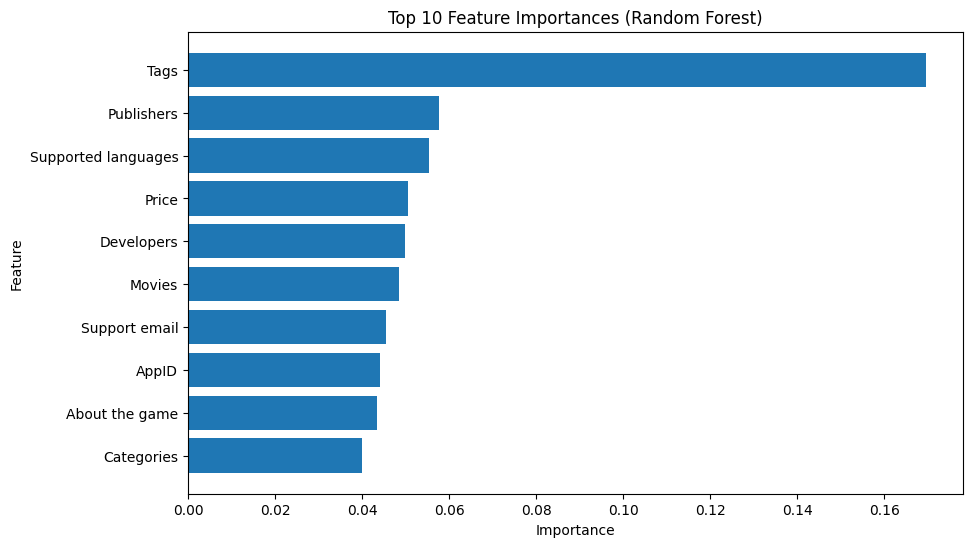

In [14]:
# prompt: gere um gráfico de barras horizontais que mostra as 10 features mais impportantes do rf_model

import pandas as pd
import matplotlib.pyplot as plt

# Get feature importances from the trained RandomForestClassifier
feature_importances = rf_model.feature_importances_

# Get feature names
feature_names = X.columns

# Create a DataFrame for easier sorting
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Get the top 10 features
top_10_features = feature_importance_df.head(10)

# Create the horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.gca().invert_yaxis()  # Invert y-axis to show highest importance at the top
plt.show()


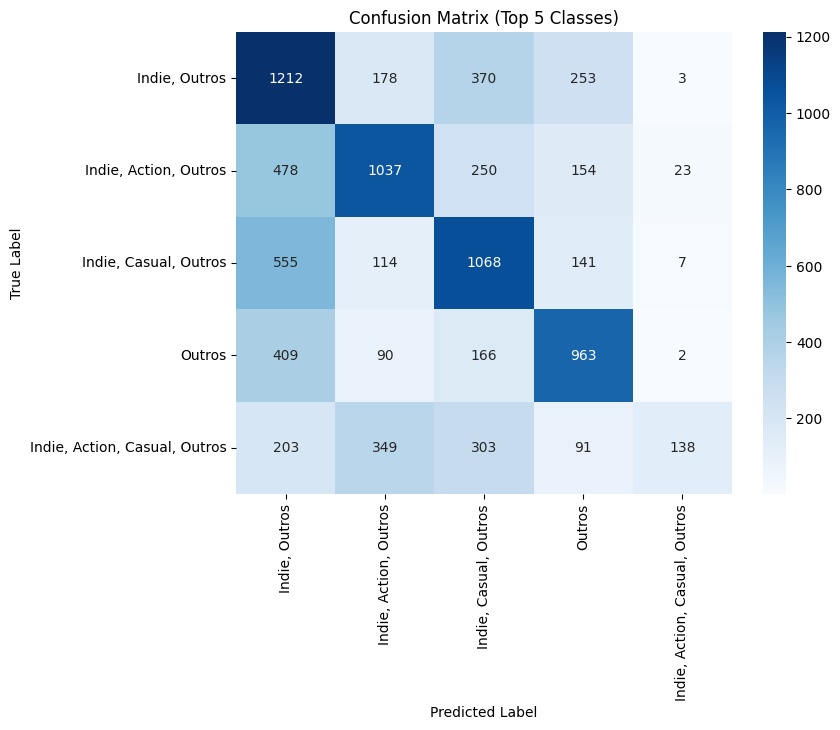

In [15]:
# prompt: gere um código que mostra a o gráfico da matriz de confusão para o rf_model mas somente para os 5 primeiros valores

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_rf_test)

# Get the first 5 classes
top_5_classes = np.argsort(np.sum(cm, axis=1))[::-1][:5]

# Subset the confusion matrix
cm_top_5 = cm[top_5_classes][:, top_5_classes]

# Plot the confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_top_5, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoders['Genres'].inverse_transform(top_5_classes),
            yticklabels=label_encoders['Genres'].inverse_transform(top_5_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Top 5 Classes)')
plt.show()


In [ ]:
# prompt: use o SHAP para analisar o modelo RandomForest chamado rf_model

# Create a SHAP explainer object
explainer = shap.TreeExplainer(rf_model)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Plot the SHAP dependence plot for a specific feature
# Replace 'feature_name' with the actual name of the feature you want to analyze
#shap.dependence_plot('feature_name', shap_values, X_test)

# Plot the SHAP force plot for a specific instance
# Replace 'instance_index' with the index of the instance you want to analyze
#shap.force_plot(explainer.expected_value, shap_values[instance_index,:], X_test.iloc[instance_index,:])


In [13]:


# Criar e treinar o modelo MLP
model = MLPClassifier(max_iter=500, verbose=True, tol=0.0000100,solver = 'adam',hidden_layer_sizes = (50, 100, 50),activation = 'relu',random_state=22)
model.fit(X_train, y_train)
MLPClassifier()

# Fazer previsões e avaliar o modelo
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
#metricas do teste
accuracy_model = accuracy_score(y_test, y_pred)
precision_score_model = precision_score(y_test, y_pred, average='weighted', zero_division=0.0)
recall_score_model = recall_score(y_test, y_pred, average='weighted', zero_division=0.0)
f1_score_model = f1_score(y_test, y_pred, average='weighted', zero_division=0.0)
#metricas do treino
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_score_train = precision_score(y_train, y_pred_train, average='weighted', zero_division=0.0)
recall_score_train = recall_score(y_train, y_pred_train, average='weighted', zero_division=0.0)
f1_score_train = f1_score(y_train, y_pred_train, average='weighted', zero_division=0.0)

#
print(classification_report(y_test, y_pred, zero_division=0.0))
print("-" * 50)
print(f"Acurácia no conjunto de treinamento: {accuracy_train}")
print(f"Precisão no conjunto de treinamento: {precision_score_train}")
print(f"Recall no conjunto de treinamento: {recall_score_train}")
print(f"F1-score no conjunto de treinamento: {f1_score_train}")
print("-" * 50)
print(f"Acurácia no conjunto de teste: {accuracy_model}")
print(f"Precisão no conjunto de teste: {precision_score_model}")
print(f"Recall no conjunto de teste: {recall_score_model}")
print(f"F1-score no conjunto de teste: {f1_score_model}")

Iteration 1, loss = 2.31684169
Iteration 2, loss = 2.13804436
Iteration 3, loss = 2.08998893
Iteration 4, loss = 2.05720784
Iteration 5, loss = 2.03043213
Iteration 6, loss = 2.00944053
Iteration 7, loss = 1.99084234
Iteration 8, loss = 1.97777283
Iteration 9, loss = 1.96512427
Iteration 10, loss = 1.95319121
Iteration 11, loss = 1.94282852
Iteration 12, loss = 1.93339229
Iteration 13, loss = 1.92488298
Iteration 14, loss = 1.91574949
Iteration 15, loss = 1.90550104
Iteration 16, loss = 1.89668262
Iteration 17, loss = 1.89124475
Iteration 18, loss = 1.88116749
Iteration 19, loss = 1.87462329
Iteration 20, loss = 1.86602147
Iteration 21, loss = 1.86159510
Iteration 22, loss = 1.85522815
Iteration 23, loss = 1.84750521
Iteration 24, loss = 1.84287516
Iteration 25, loss = 1.83763819
Iteration 26, loss = 1.83372547
Iteration 27, loss = 1.83021079
Iteration 28, loss = 1.82347730
Iteration 29, loss = 1.81847964
Iteration 30, loss = 1.81438948
Iteration 31, loss = 1.81184327
Iteration 32, los

In [12]:
# prompt: crie um modelo KNN com no máximo 20 vizinhos e treine Utilizando  X_train,  y_train.  faça a previsão do grupo de treino X_train e do grupo de teste X_test e calcule as métricas de teste e de treino. Printe o classification_report e todas as métricas calculadas

from sklearn.neighbors import KNeighborsClassifier

# Criar e treinar o modelo KNN
knn_model = KNeighborsClassifier(n_neighbors=20)
knn_model.fit(X_train, y_train)

# Fazer previsões
y_pred_knn_train = knn_model.predict(X_train)
y_pred_knn_test = knn_model.predict(X_test)

# Métricas para o conjunto de treinamento
accuracy_knn_train = accuracy_score(y_train, y_pred_knn_train)
precision_knn_train = precision_score(y_train, y_pred_knn_train, average='weighted', zero_division=0.0)
recall_knn_train = recall_score(y_train, y_pred_knn_train, average='weighted', zero_division=0.0)
f1_knn_train = f1_score(y_train, y_pred_knn_train, average='weighted', zero_division=0.0)

# Métricas para o conjunto de teste
accuracy_knn_test = accuracy_score(y_test, y_pred_knn_test)
precision_knn_test = precision_score(y_test, y_pred_knn_test, average='weighted', zero_division=0.0)
recall_knn_test = recall_score(y_test, y_pred_knn_test, average='weighted', zero_division=0.0)
f1_knn_test = f1_score(y_test, y_pred_knn_test, average='weighted', zero_division=0.0)

# Imprimir as métricas
print(classification_report(y_test, y_pred_knn_test, zero_division=0.0))
print("-" * 50)
print(f"Acurácia no conjunto de treinamento: {accuracy_knn_train}")
print(f"Precisão no conjunto de treinamento: {precision_knn_train}")
print(f"Recall no conjunto de treinamento: {recall_knn_train}")
print(f"F1-score no conjunto de treinamento: {f1_knn_train}")
print("-" * 50)
print(f"Acurácia no conjunto de teste: {accuracy_knn_test}")
print(f"Precisão no conjunto de teste: {precision_knn_test}")
print(f"Recall no conjunto de teste: {recall_knn_test}")
print(f"F1-score no conjunto de teste: {f1_knn_test}")


              precision    recall  f1-score   support

           0       0.92      0.98      0.95       488
           1       0.29      0.14      0.19       403
           2       0.00      0.00      0.00        69
           3       0.11      0.01      0.02       201
           4       0.24      0.10      0.14       765
           5       0.30      0.26      0.28       387
           6       0.32      0.24      0.27       694
           7       0.16      0.10      0.12       411
           8       0.16      0.12      0.14       752
           9       0.16      0.06      0.09       452
          10       0.16      0.13      0.14      1162
          11       0.22      0.31      0.26      2048
          12       0.24      0.29      0.26       788
          13       0.22      0.33      0.27      1994
          14       0.23      0.28      0.26      2053
          15       0.38      0.31      0.34      1677

    accuracy                           0.26     14344
   macro avg       0.26   